## Supervised Learning
## Project: Finding Donors for *CharityML*

## Getting Started

In this project, I am going to employ several supervised methods to accurately model individuals' income using data collected from the 1994 U.S. Census. I will then choose the best candidate model from preliminary results and further optimize this model to increase the accuracy of the predictions. My goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000.

While this task can arise in any firm, the main notion behind this project is to display my take on employing these models in order to correctly identify induviduals or groups of induviduals. Understanding an individual's income can help a firm understand how much of their time and effort they should spend, in order to decide if these will lead to successfull sales. While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

## Exploring the Data

Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")
data.dropna(inplace=True)

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, I am going to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.



In [2]:
#Total number of records
n_records = len(data)

#Number of records where individual's income is more than $50,000
n_greater_50k = data[(data['income'] == ">50K")]
n_greater_50k = len(n_greater_50k)


#Number of records where individual's income is at most $50,000
n_at_most_50k=  data[(data['income'] == "<=50K")]
n_at_most_50k=  len(n_at_most_50k)

#Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k/n_records)* 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


### **Featureset Exploration**

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning model.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 



In [3]:
 """Visualization code for displaying skewed distributions of features
    
def distribution(data, transformed = False):
    
    # Create figure
    fig = pl.figure(figsize = (11,5));

    # Skewed feature plotting
    for i, feature in enumerate(['capital-gain','capital-loss']):
        ax = fig.add_subplot(1, 2, i+1)
        ax.hist(data[feature], bins = 25, color = '#00A0A0')
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")
        ax.set_ylim((0, 2000))
        ax.set_yticks([0, 500, 1000, 1500, 2000])
        ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

    # Plot aesthetics
    if transformed:
        fig.suptitle("Log-transformed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)
    else:
        fig.suptitle("Skewed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)

    fig.tight_layout()
    fig.show()
    '''

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-3-7e9566cf5dd1>, line 29)

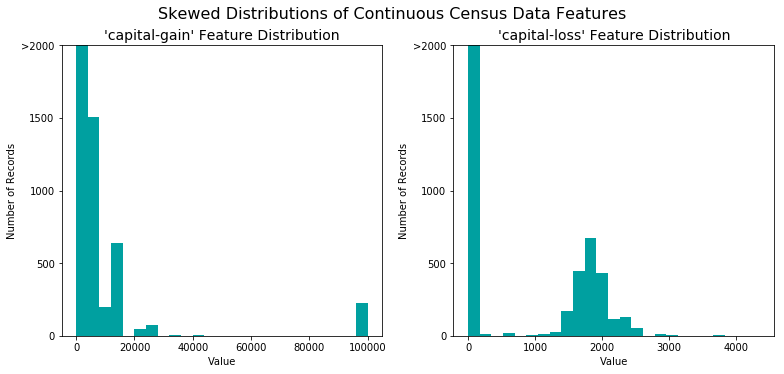

In [3]:
# Splitting the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)


For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

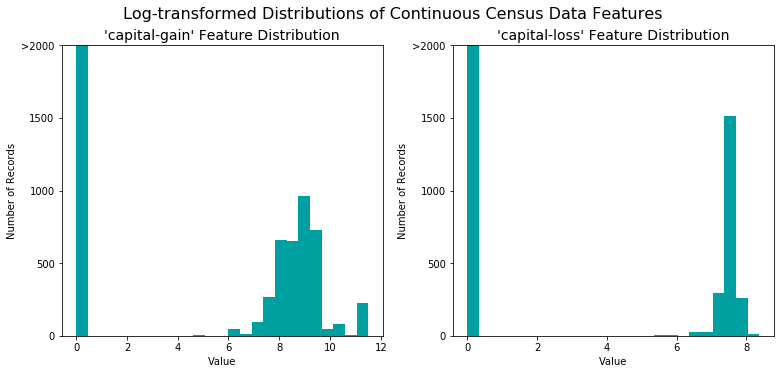

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. 

In [6]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)


# TODO: Encode the 'income_raw' data to numerical values
income_raw = pd.DataFrame(data = income_raw)
income = income_raw['income'].map({'<=50K': 0, '>50K': 1})


# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print(encoded)  

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.


In [7]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate but not sufficient. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's **precision**  (ability to precisely predict those that make more than \$50,000) is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for the data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? 

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally the base model would be either the results of a previous model or could be based on a research paper upon which the team is looking to improve. When there is no benchmark model set, getting a result better than random choice is a place to start from.

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [22]:
# Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
#encoded to numerical values done in the data preprocessing step.
TP = np.sum(income)
FP = income.count() - TP 

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

#Calculate accuracy, precision and recall
accuracy = (TP + TN)/(45221)
recall = (TP)/(TP+FN)
precision = (TP)/(TP+FP)

#Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
b = 0.5
fscore = (1+b**2)*(precision*recall)/(b**2*precision+recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]
1.0 0.2478439697492371


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that I will choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
For the three supervised model that I have chosen for this problem, I am going to answer the following. 

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what we know about the data?


### The three algorithms I have chosen are : 

- Decision Trees
- Ensemble Method (Adaboost) 
- Support Vector Machine 

## Decision Trees

A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements. Decision trees are commonly used in operations research, specifically in decision analysis, to help identify a strategy most likely to reach a goal.

### Strength - 
- Decision Trees require little data preparation. Other techniques often require data normalization, dummy variables need to be created and blank values to be removed.
- The cost of using the tree (i.e., predicting data) is logarithmic in the number of data points used to train the tree.
- Able to handle both numerical and categorical data. Other techniques are usually specialized in analyzing datasets that have only one type of variable. 
- Uses a white box model. If a given situation is observable in a model, the explanation for the condition is easily explained by Boolean logic. By contrast, in a black box model (e.g., in an artificial neural network), results may be more difficult to interpret.
- Possible to validate a model using statistical tests. That makes it possible to account for the reliability of the model.

### Weakness - 

- Decision-tree learners can create over-complex trees that do not generalize the data well. This is called overfitting. Mechanisms such as pruning, setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.

- Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. This problem is mitigated by using decision trees within an ensemble.

- Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the dataset prior to fitting with the decision tree.

Decision Trees is a good model for this dataset because 

- Each datapoint has multiple features. 
- The project is based on classification.
- Dataset has more than 1000 datapoints.

## Ensemble Method (adaboost) 

Adaboost, relies on fitting a sequence of weak learners(regular machine learning models) on repeatedly modified versions of data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. Adaboost is often used in Decision Trees to reduce bias and variance of the predicted outcomes. 

### Strength - 
- Adaboost can be implemented on any algorithm as it is a method that calculates the weighted average from a base model to make predictions. Thereby, enabling more accurate and precise predictions. 

- Adaboost can also be implemented in contexts where there are repeated iterations, such as transactions of loyal customers to extrapolate customer purchasing patterns and then incorporating a marketing strategy on it. 

### Weakness- 

- The accuracy of the predictions made by Adaboost depend on the classification/regression algorithms that were set as the base parameter. If the adaboost method is based on the wrong type of algorithm, this error will be perputated throughout the predictions made. 

- AdaBoost can be sensitive to noisy data and outliers since it requires careful tuning of hyper parameters. 

Ensemble Method is a good model for this dataset because 

- The dataset is labelled. 
- The project is based on classification.
- Dataset has more than 1000 datapoints.

## Support Vector Machine 

Support Vector Machine is a classification algorithm that creates the plot of the datapoints on n-dimensional hyperplane based on the number of predictors available. This is done to maximize the distance between the points that have been mapped to make accurate classification predictions. The SVM algorithm has been widely applied in the biological and other sciences. They have been used to classify proteins with up to 90% of the compounds classified correctly. 

### Strength 
- SVM is found to be effective in high dimensional spaces, especially in cases where number of dimensions is greater than the number of samples.

- SVM uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.

- SVM is a versatile algorithm as different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.


### Weakness 
- If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.

- SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation (see Scores and probabilities, below).

SVM is a good model for this dataset because 

- It supports both classification and regression. 
- Data entries have multiple features.


### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model I have chosen, it's important to create a training and predicting pipeline that allows me to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. My implementation here will be used in the following section.
In the code block below, I will implement the following:
 - Importing `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fitting the learner to the sampled training data and record the training time.
 - Performing predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculating the accuracy score for both the training subset and testing set.
 - Calculating the F-score for both the training subset and testing set.


In [9]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score 
from sklearn.metrics import accuracy_score 


def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    #Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    #Calculate the training time
    results['train_time'] = end - start
        
    #Get the predictions on the test set(X_test),
    #then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    #Calculate the total prediction time
    results['pred_time'] = end - start
            
    #Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    #Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    #Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,beta = 0.5)
        
    #Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test,predictions_test, beta = 0.5)
       
    #Print the sample size trained on
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    #Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, I will implement the following:
- Importing the three supervised learning models I've discussed in the previous section.
- Initializing the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Using a `'random_state'` for each model used, if provided.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms are chosen, the following implementation may take some time to run!

In [10]:
"""
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
 """
def evaluate(results, accuracy, f1):
  
    # Create figure
    fig, ax = pl.subplots(2, 3, figsize = (11,7))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")
    
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    pl.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    pl.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    pl.tight_layout()
    pl.show()
    


AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC trained on 361 samples.
SVC trained on 3617 samples.


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC trained on 36177 samples.


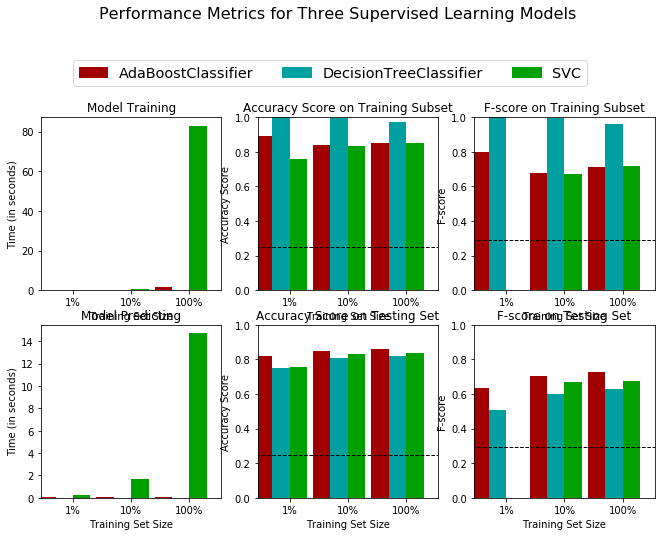

In [11]:
#Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm


#Initialize the three models
clf_A = AdaBoostClassifier(random_state=10)
clf_B = DecisionTreeClassifier(random_state = 10)
clf_C = svm.SVC( random_state = 10)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(X_train)
samples_10 = int(samples_100/10)
samples_1 = int(samples_100/100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)


## Improving Results
In this final section, I will choose from the three supervised learning models the *best* model to use on the student data. I will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation I performed earlier, I am going to explain to the client/management which of the three models I believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

Initially, I had proposed that SVM will have the most accurate prediction and will be the best model to predict income. However, after evaluation it turns out that SVM is not as efficient as it proves to be accurate. Consider the following data from the F-score evaluation

F-score Approximations from the Visualization
- Adaboost - 72 % 
- DecisionTree - 62-65%
- SVM - 65-67%

From the above stated F-scores of the implemented models, Adaboost has the best performance out of all models. This was not surprising as Adaboost is an ensemble method that uses weighted averaging to generate a prediction on a base predictor(weak learner or base model such as Naive Bayes). In this case, the weak learner was Decision Trees. 

On the other hand, while SVM has higher accuracy and F-score than Decision Trees on the training and testing set, SVM suffers from elongated training time. This becomes evident when 100% of the training set is used on the algorithm. It takes SVM almost 100 seconds to train and predict the data points. While Adaboost and Decision Tree Classifier have approximately 10 seconds to train and predict the data. This can become troublesome. Mathematically speaking, if it takes the model to 80 seconds to train the 36177 samples, the model can take well more than 2 hours for data that has 3 million data points. This makes the SVM model unscalable to be tested on large amounts of data.  

In conclusion, the best performing model for this dataset is Adaboost for the following reason:-
- Uses a base model and produces a weighted average prediction which is usually more accurate than the base model’s prediction itself. 
- Can be implemented primarily for classification problems 
- Performs well for binary classification, as in this scenario ( ‘<50K’ or ‘>=50K’)



### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, I am going to explain, in layman's terms, how the final model chosen is supposed to work. 

AdaBoost was formulated by Yoav Freund and Robert Schapire. Problems in machine learning tend to suffer from the curse of dimensionality, means a single data point can have many features. So if each sample consists of a huge number of potential features, the overall system becomes very slow. This is the reason we cannot use a powerful model with a full feature set because it cannot run in real time. If the algorithms are too simple, they tend to be less accurate. They are called ‘weak learners’. So we cascade them together to create a strong classifier. The output of ‘weak learners’ is combined into a weighted sum that represents the final output of the boosted classifier.

AdaBoost is adaptive in the sense that subsequent weak learners are tweaked in favor of those instances misclassified by previous classifiers. When we collect the set of weak learners, we give equal weights to all of them. But on each round, the weights of incorrectly classified examples are increased so that the weak learner is forced to focus on the hard examples in the training set. 

#### Example 

A horse-racing gambler wants to maximize his winnings and decides to create a computer program that will accurately predict the winner of a horse race based on the usual information. This information can be the number of races recently won by each horse, weather conditions, betting odds for each horse, etc. The program will take all these parameters into account and predict the winner for each race. To create such a program, the gambler asks a highly successful gambler to explain his betting strategy. But somehow, the expert is unable to articulate a grand set of rules for selecting a horse. He just considers all these factors subconsciously and goes with the best guess.

When the gambler presents all the data for a specific set of races, the expert can easily come up with a rule of thumb for that set of races. For example, he can ask you to bet on the horse that has recently won the most races, or may be bet on the horse with the most favored odds. Again, such a rule of thumb is obviously very rough and inaccurate by itself. It is not unreasonable to expect it to provide predictions that are at least a little bit better than random guessing. If you keep asking the expert’s opinion on different collections of races, you can extract many rules of thumb. Now if the program takes all these rules of thumb into account, there is a much better chance of coming up with a good predictor. 


### Implementation: Model Tuning
Here I am going to fine tune the chosen model, using grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. I am going to use the entire training set for this. In the code cell below, I am implementing the following:
- Importing [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initializing the classifier I have chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state I set before.
- Creating a dictionary of parameters I am going to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Using `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Performing grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fitting the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [12]:
#Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier

#Initialize the classifier
clf = AdaBoostClassifier()

#Create the parameters list I am going to tune, using a dictionary if needed.
# parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
'''
The number of weak learners is controlled by the parameter n_estimators. 
The learning_rate parameter controls the contribution of the weak learners in the final combination. 
By default, weak learners are decision stumps. Different weak learners can be specified through the base_estimator parameter. 
The main parameters to tune to obtain good results are n_estimators and the complexity of the base estimators 
(e.g., its depth max_depth or minimum required number of samples to consider a split min_samples_split).
There is a trade-off between learning_rate and n_estimators.
'''

parameters = {'base_estimator': [DecisionTreeClassifier(max_depth=1)], 'n_estimators':[1000],'learning_rate':[1]}


#Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

#Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(estimator = clf, param_grid = parameters,scoring = scorer )

#Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train,y_train)

#Get the estimator
best_clf = grid_fit.best_estimator_

#Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

#Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8676
Final F-score on the testing data: 0.7448


In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,best_predictions)

array([[6430,  410],
       [ 788, 1417]])

### Question 5 - Final Model Evaluation

* What is the optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from the optimized model compare to the naive predictor benchmark in **Question 1**?_  



#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.8576       |     0.8676      |
| F-score        |      0.7246       |     0.7448      |


In [21]:
TP = 6430#True Positive
TN= 788#True Negative 
FP= 410#False Positive 
FN= 1417#False Negative 

accuracy = (TP + TN)/(45221)
recall = (TP)/(TP+FN)
precision = (TP)/(TP+FP)

print("Naive Predictor: [Accuracy score: {:.4f}, Recall: {:.4f},Precision: {:.4f}]".format(accuracy, recall,precision))

Naive Predictor: [Accuracy score: 0.1596, Recall: 0.8194,Precision: 0.9401]


**Evaluation: **

From the above confusion matrix, we calcualted the Recall of our model - 81.94% and Precision - 94.01%. 
It is important to understand these metrics to analyze the performance of our model.  In this assignment, tasked with finding consumers who are most likely to purchase the product or service, by predicting their income status, a false positive (a consumer who isnt likely to purchase) is not dentrimental to the goal as much as someone who is inclined to buy but has been left out of the targeted demographic (false negative), which would impact sales target dramatically. The model has higher number of false negatives than false positives. This means that there is a likelihood that 
there is a 18.06% chance of missing interested buyers in our dataset.

The optimized model had an accuracy score of 86.76% which is 1% better than the unotimized model. The optimized model had also a higher F-score 2.02%. These scores are better than the unoptimized model. 
In question 1, the accuracy obtained for the model is 24.78% and the F-score obtained for the model is 29.17%. The accuracy of our model has increased by 61.98% and the F-score by 45.31%.

## Feature Importance

An important task when performing supervised learning on a dataset is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features is the most important for prediction, and in what order should they be ranked and why?


### Capital Gain 
I have picked Capital Gain as the most important feature to be explored since the capital gain of an induvidual represents its potential monetary gain.

### Occupation 
I have ranked occupation as the most important predictor because occupation has been empirically asumed to be the primary predictor of an induvidual's net worth. For instance, consider that the national median slary for a physician is aproxmately $190,000, Whereas for a accountant it is $70,000. 

### Education 
Education has also been considered another important predictor of an inducidual's net worth. Simply because Education is considered one of the most important factors in determining Occupation. The mean salary of a graduate is $60,000.  Post-graduates have higher salary than graduates, by more than atleast $70,000.

### Age
Age of the induvidual might imply the net worth of the induvidual. One reason is that the average CEO who is aged 60 years old, takes home $114,000. The CEO is considered the head of operations, financial and day-to-day activities of the firm. The above implies that the since the higher age of CEO is correlated with income,as they have the highest compensation out of all their employees.

### Capital Loss
Finally, I picked Capital Loss as one of the important features in this dataset, because I believe that Capital Loss  represents the annual capital the induvidual will lose for their debt or other payments. This will in turn affect how much the person's net annual salary.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, I am going to implement the following:
 - Importing a supervised learning model from sklearn if it is different from the three used earlier.
 - Training the supervised model on the entire training set.
 - Extracting the feature importances using `'.feature_importances_'`.

In [4]:
### Feature Visualization plot
'''

def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = pl.figure(figsize = (9,5))
    pl.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    pl.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    pl.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    pl.xticks(np.arange(5), columns)
    pl.xlim((-0.5, 4.5))
    pl.ylabel("Weight", fontsize = 12)
    pl.xlabel("Feature", fontsize = 12)
    
    pl.legend(loc = 'upper center')
    pl.tight_layout()
    pl.show()  
    
    '''


'\n\ndef feature_plot(importances, X_train, y_train):\n    \n    # Display the five most important features\n    indices = np.argsort(importances)[::-1]\n    columns = X_train.columns.values[indices[:5]]\n    values = importances[indices][:5]\n\n    # Creat the plot\n    fig = pl.figure(figsize = (9,5))\n    pl.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)\n    pl.bar(np.arange(5), values, width = 0.6, align="center", color = \'#00A000\',           label = "Feature Weight")\n    pl.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = \'#00A0A0\',           label = "Cumulative Feature Weight")\n    pl.xticks(np.arange(5), columns)\n    pl.xlim((-0.5, 4.5))\n    pl.ylabel("Weight", fontsize = 12)\n    pl.xlabel("Feature", fontsize = 12)\n    \n    pl.legend(loc = \'upper center\')\n    pl.tight_layout()\n    pl.show()  \n    \n    '

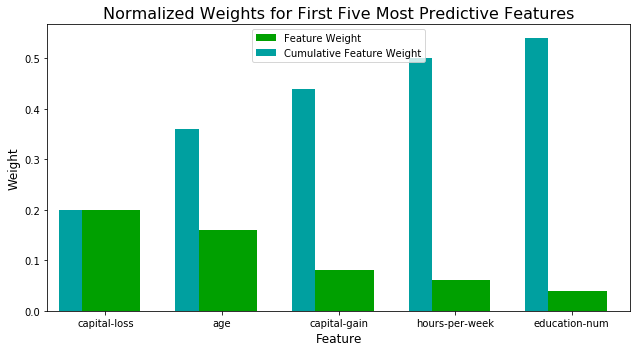

In [13]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier

# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier().fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the chosedn five features in **Question 6**?
* If it is close to the same answer, how does this visualization confirm the thoughts? 
* If it is not close, why are these features are more relevant?

**Answer:**

Out of the five predictors that I hypothesized only 2 of them have been confirmed by the model(capital-loss and capital-gain). From the above it can be understood that age and capital gain are the best predictors of wealth. 

However, I was surprised to see that "hours-per week" is the second most important predictor. Perhaps one of the reason for this could be the fact I had assumed, inaccurately, that most of the jobs that are paid on the hour are blue collar jobs. It is possible that people occupying higher management positions in companies often have busy lives, are known to tout 100 hour workweeks and could be paid by the hour i.e consultants and lawyers. It was interesting to notice that the model was able to make this decision despite my previous conceived bias about the predictor.


### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model I found earlier, and train it on the same training set *with only the top five important features*. 

In [14]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8676
F-score on testing data: 0.7448

Final Model trained on reduced data
------
Accuracy on testing data: 0.8433
F-score on testing data: 0.7053


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would the reduced data be considered as the training set?

**Answer:**
The final F-score and accuracy for reduced data are lower than that of the full data. Accuracy of the model is reduced by 2.43% and the F-score is reduced by 3.95%.

Taking into account training as a factor, when looking at the reduction in the magnitude of the accuracy and F-score of the model, I would not mind it. Considering how the reduced dataset underperforms the 13 feature original model by merely 4%, if the dataset is large, using a reduced dataset for this task will greatly save the project group costs on GPU processing and cloud storage. 

However, if the above model doesn't meet the accracy requirements of the scope of the project, then another way to increase the accuracy would be to have try feature reduction process with other model such as SVM. It is to be noted that models that aim for higher accuracy also tend to overfit.